## Asset Dynamics 

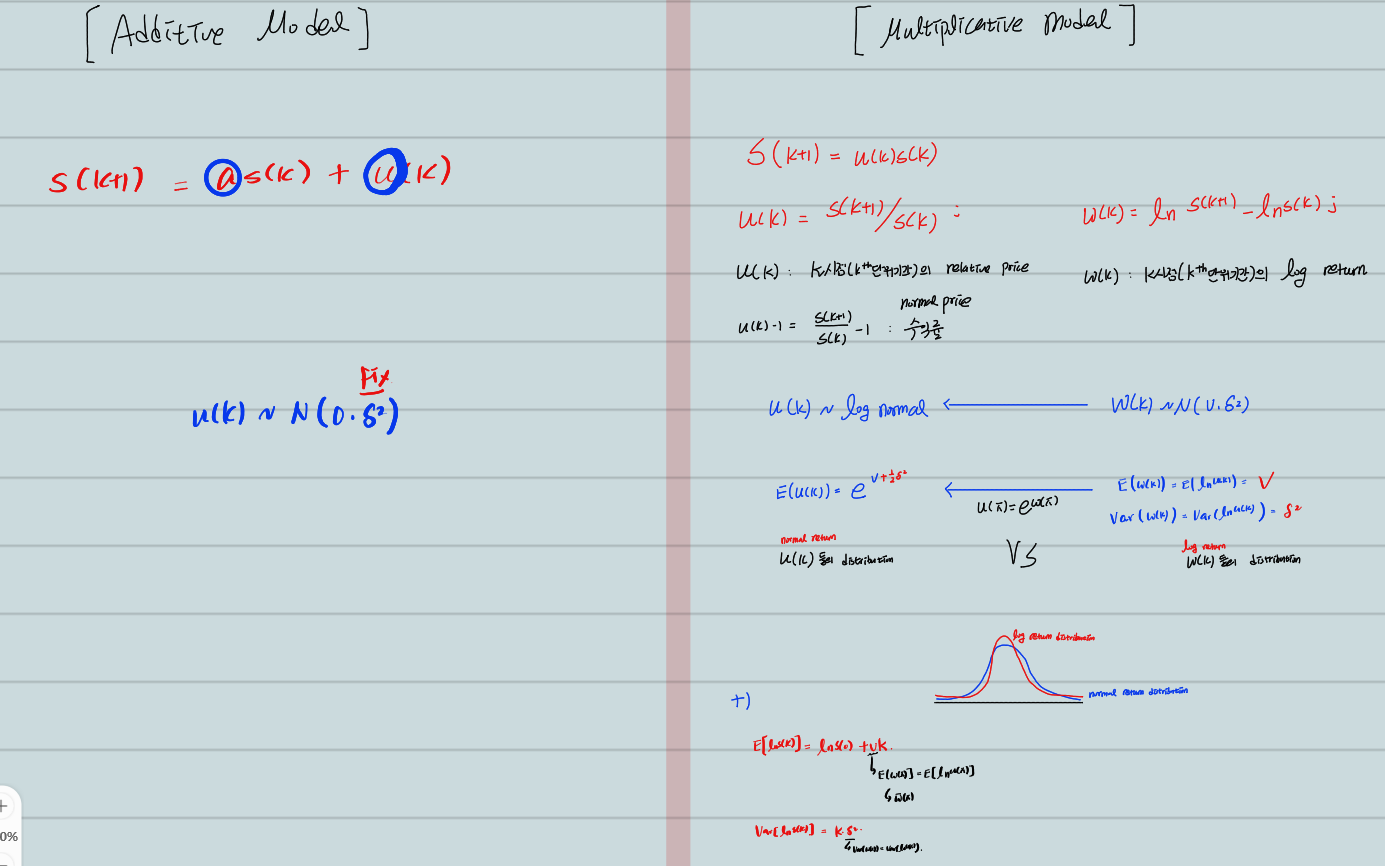

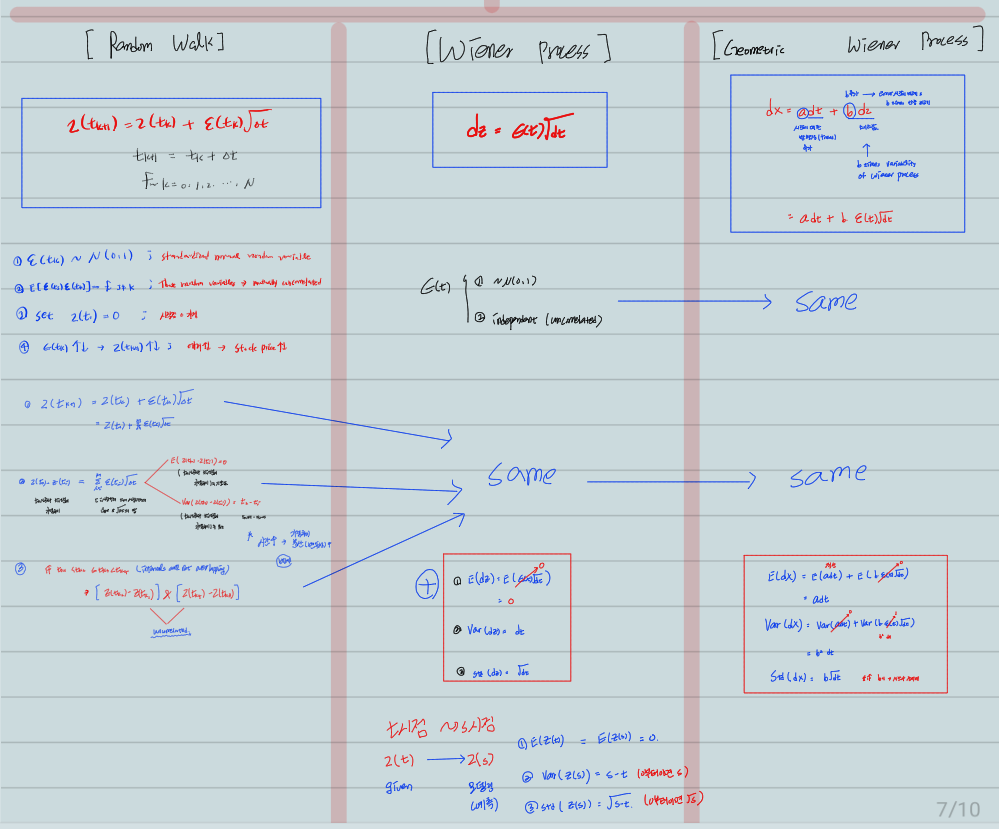

## GBM
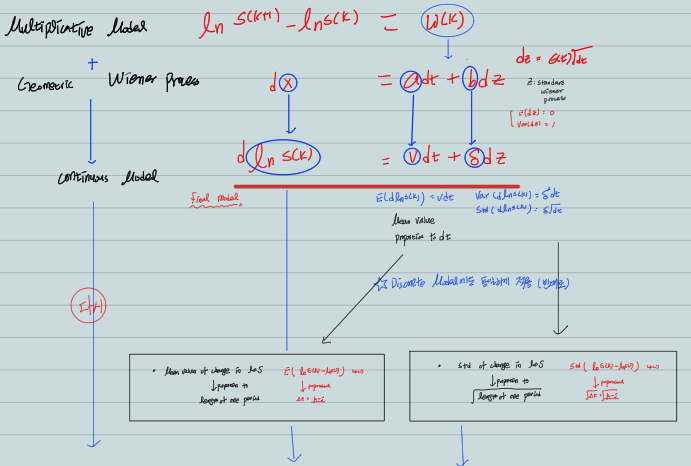


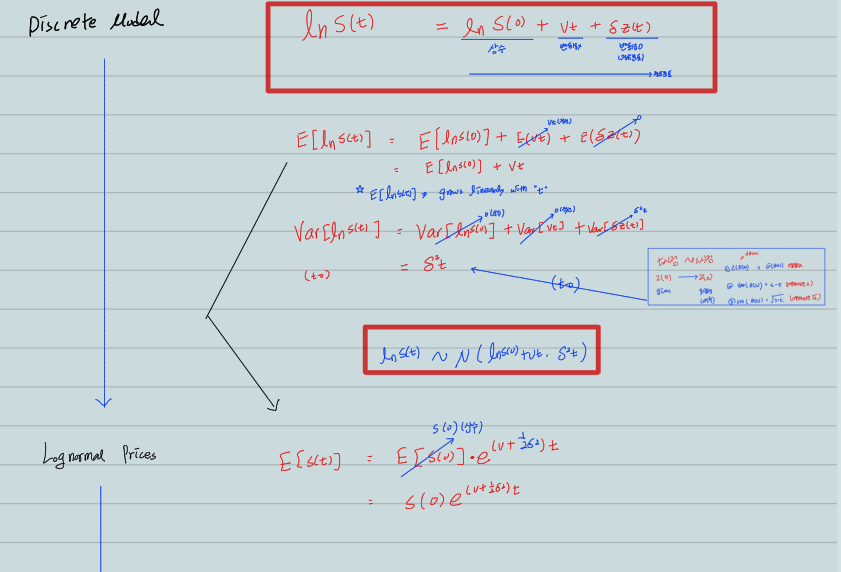


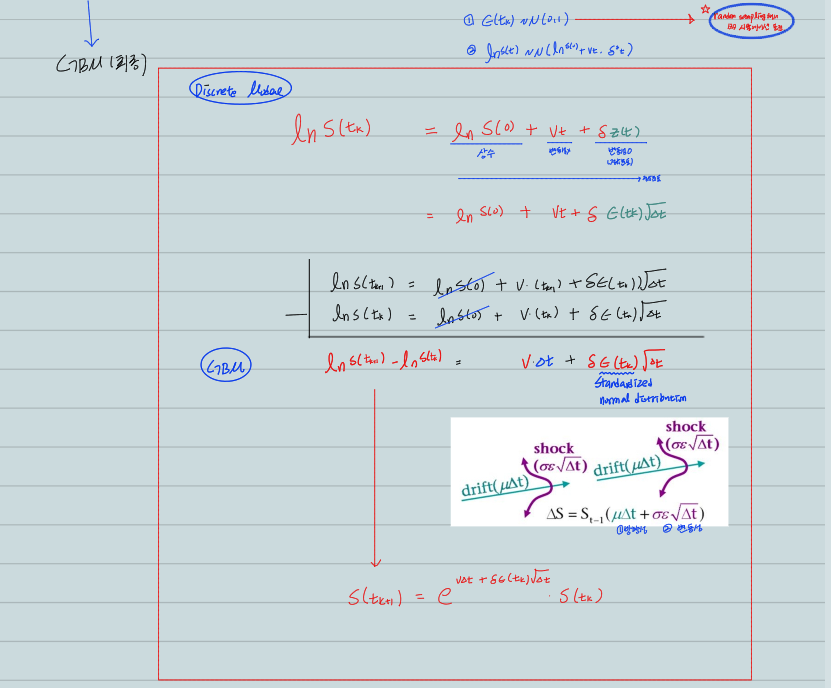


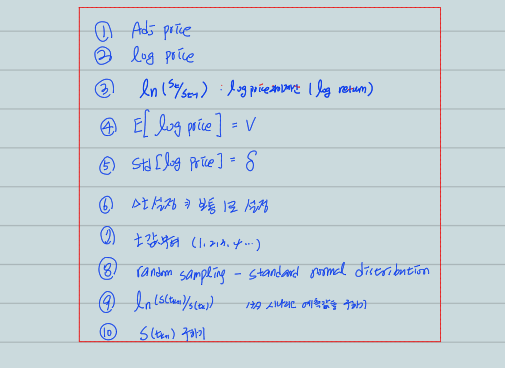


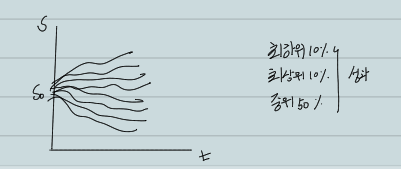


In [1]:
!pip install pandas-datareader

In [2]:
import pandas as pd 
import pandas_datareader as web
import numpy as np
import matplotlib.pyplot as plt 
import statsmodels.api as sm
%matplotlib inline 

In [3]:
#Adj Price
df = web.get_data_yahoo('META', start = '2020-01-01', end='2020-12-31')['Adj Close']
df

Date
2020-01-02    209.779999
2020-01-03    208.669998
2020-01-06    212.600006
2020-01-07    213.059998
2020-01-08    215.220001
                 ...    
2020-12-24    267.399994
2020-12-28    277.000000
2020-12-29    276.779999
2020-12-30    271.869995
2020-12-31    273.160004
Name: Adj Close, Length: 253, dtype: float64

In [4]:
#Adj return 
ret = df.pct_change()
ret = ret.dropna()
ret

Date
2020-01-03   -0.005291
2020-01-06    0.018834
2020-01-07    0.002164
2020-01-08    0.010138
2020-01-09    0.014311
                ...   
2020-12-24   -0.002648
2020-12-28    0.035901
2020-12-29   -0.000794
2020-12-30   -0.017740
2020-12-31    0.004745
Name: Adj Close, Length: 252, dtype: float64

In [5]:
# log price 

log_price = np.log(df)
log_price

Date
2020-01-02    5.346059
2020-01-03    5.340754
2020-01-06    5.359412
2020-01-07    5.361574
2020-01-08    5.371661
                ...   
2020-12-24    5.588746
2020-12-28    5.624018
2020-12-29    5.623223
2020-12-30    5.605324
2020-12-31    5.610058
Name: Adj Close, Length: 253, dtype: float64

In [6]:
# log return 

log_return = log_price.shift(-1) - log_price
log_return = log_return.dropna()
log_return

Date
2020-01-02   -0.005305
2020-01-03    0.018658
2020-01-06    0.002161
2020-01-07    0.010087
2020-01-08    0.014210
                ...   
2020-12-23   -0.002652
2020-12-24    0.035272
2020-12-28   -0.000795
2020-12-29   -0.017899
2020-12-30    0.004734
Name: Adj Close, Length: 252, dtype: float64

In [7]:
# V = E[log return] = E[lnSt-lnSt-1]

V = log_return.mean() # t변화량 = 하루 

# std = std[log return]

std = np.sqrt(log_return.var()) # t변화량 = 하루 

print(V)
print(std)

0.0010476125427970695
0.02904944782938049


In [8]:
# t변화량 - 하루 

t_change = 1 

# 100일 예측 

t_value = np.arange(1, 101, 1) #start, stop, step 
t_value

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

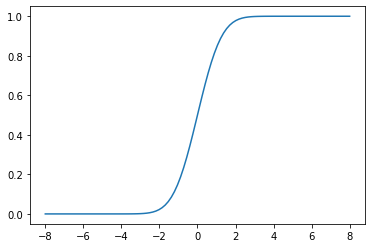

In [9]:
# 0~1 값부여 -> 정규분포 cdf의 inverse 값들로부여 

import scipy as sp
import scipy.stats

rv = sp.stats.norm()

xx = np.linspace(-8, 8, 100)
cdf = rv.cdf(xx)
plt.plot(xx, cdf)

In [10]:
Epsilon = np.random.choice(cdf, size=t_value.shape)

In [11]:
# Epsilon 여러개 생성 

Epsilon_list = [] 

for i in range(10000): 
    Eps = np.random.standard_normal(t_value.shape[0])
    Epsilon_list.append(Eps)

Epsilon_list[0].shape

(100,)

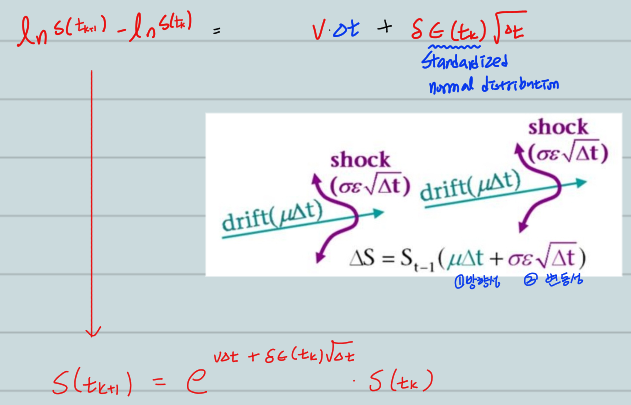

In [12]:
# 난수값 부여 log_return 

log_return_senario_list = [] 
price_return_senario_list = []

for Eps in Epsilon_list:
    log_return_senario = V*t_change + std*Eps*np.sqrt(t_change)
    log_return_senario = pd.Series(log_return_senario, index= t_value)
    log_return_senario_list.append(log_return_senario)
    
    price_return_senario = np.exp(log_return_senario) - 1 
    price_return_senario_list.append(price_return_senario)
    
    


In [13]:
log_return_senario_list[0]  # v+s*Error

1      0.051276
2     -0.038631
3      0.005420
4     -0.003782
5      0.011041
         ...   
96     0.016926
97    -0.009600
98     0.016412
99     0.007119
100   -0.001057
Length: 100, dtype: float64

In [14]:
price_return_senario_list[0] # e^(v+s*Error)

1      0.052613
2     -0.037895
3      0.005435
4     -0.003775
5      0.011102
         ...   
96     0.017070
97    -0.009554
98     0.016547
99     0.007144
100   -0.001056
Length: 100, dtype: float64

In [15]:
# 10000개 시나리오 return들의 expected return, standarad deviation of return 구하기 

price_expected_return_list= []
price_risk_list = []
log_expected_return_list =[]
log_risk_list =[]
for price_return, log_return in zip(price_return_senario_list, log_return_senario_list):
    
    ann_price_return = price_return.mean() * 252
    ann_price_risk = np.sqrt(price_return.var() * 252)
    ann_log_return = log_return.mean() * 252
    ann_log_risk = np.sqrt(log_return.var() * 252)
    
    price_expected_return_list.append(ann_price_return)
    price_risk_list.append(ann_price_risk)
    log_expected_return_list.append(ann_log_return)
    log_risk_list.append(ann_log_risk)
    
    

In [16]:
# 구한 10000개 시나리오 return들의 expected return, standarad deviation of return 들의 percentile값들 구하기 


# price return, risk 오름차순 정렬 

price_expected_return_list.sort()
price_risk_list.sort()
log_expected_return_list.sort()
log_risk_list.sort()

# 하위 10% return,risk

lower_10_price_return = np.percentile(price_expected_return_list, 0.1)
lower_10_price_risk = np.percentile(price_risk_list, 0.1)
lower_10_log_return = np.percentile(log_expected_return_list, 0.1)
lower_10_log_risk = np.percentile(log_risk_list, 0.1)



# 중위 50% return,risk
middle_price_return = np.percentile(price_expected_return_list, 0.5)
middle_price_risk = np.percentile(price_risk_list, 0.5)
middle_log_return = np.percentile(log_expected_return_list, 0.5)
middle_log_risk = np.percentile(log_risk_list, 0.5)

# 상위 10% return,risk

upper_10_price_return = np.percentile(price_expected_return_list, 0.9)
upper_10_price_risk = np.percentile(price_risk_list, 0.9)
upper_10_log_return = np.percentile(log_expected_return_list, 0.9)
upper_10_log_risk = np.percentile(log_risk_list, 0.9)






print('price')
print('<return>')
print(lower_10_price_return, middle_price_return, upper_10_price_return)
print('<risk>')
print(lower_10_price_risk, middle_price_risk, upper_10_price_risk)
print('\n')

print("all senarios' price returns mean", np.mean(price_expected_return_list)) #이미 annaulized 되어있는 값들 -> 다시해줄필요없음 
print("all senarios' price returns std", np.sqrt(np.var(price_expected_return_list)))

print('\n')


print('log_price')
print('<return>')
print(lower_10_log_return, middle_log_return, upper_10_log_return)
print('<risk>')
print(lower_10_log_risk, middle_log_risk, upper_10_log_risk)

print('\n')


print("all senarios' log_price returns mean", np.mean(log_expected_return_list)) #이미 annaulized 되어있는 값들 -> 다시해줄필요없음 
print("all senarios' log_price returns std", np.sqrt(np.var(log_expected_return_list)))




price
<return>
-1.7791730244015471 -1.4712927031686347 -1.3238489356654255
<risk>
0.3682214308037934 0.3818188049122166 0.38766101476963616


all senarios' price returns mean 0.3689991159547766
all senarios' price returns std 0.7296487286469034


log_price
<return>
-1.8840102730741382 -1.57769457751926 -1.4308123230814362
<risk>
0.3684188683848355 0.38118170808396584 0.38637842054054566


all senarios' log_price returns mean 0.2625801418027179
all senarios' log_price returns std 0.728577201829461


## Return,risk Distribution 파악

##### 모든 return senario들의 expected return, std of return 들의 분포를 파악 

### Return 

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2103

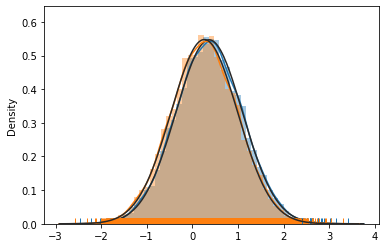

In [17]:
import seaborn as sns
import scipy as sp 

sns.distplot(price_expected_return_list, kde=True, rug= True, fit=sp.stats.norm)
sns.distplot(log_expected_return_list, kde=True, rug= True, fit=sp.stats.norm)

sns.set(rc={'figure.figsize':(20,20)})





In [18]:
# skewness -price_return_senarios'

sp.stats.skew(price_expected_return_list), sp.stats.kurtosis(price_expected_return_list)

(0.03254670671705123, -0.013408709837426702)

In [19]:
# skewness -log_return_senarios'

sp.stats.skew(log_expected_return_list), sp.stats.kurtosis(log_expected_return_list)

(0.0257240684124589, -0.014613867638971545)

### Risk  

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2103

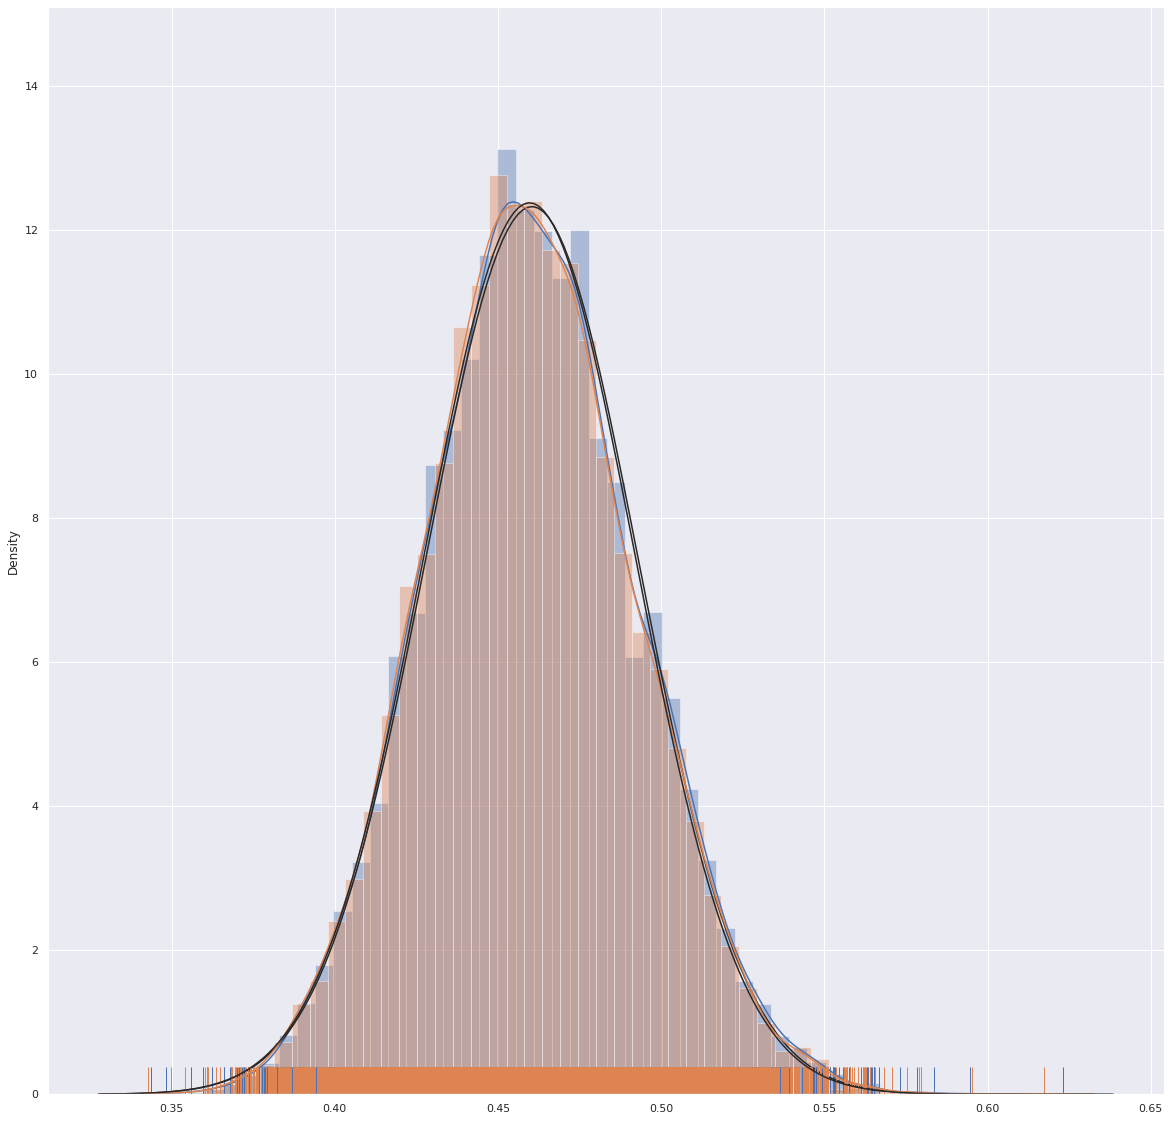

In [20]:
import seaborn as sns
import scipy as sp 

sns.distplot(price_risk_list, kde=True, rug= True, fit=sp.stats.norm)
sns.distplot(log_risk_list, kde=True, rug= True, fit=sp.stats.norm)

sns.set(rc={'figure.figsize':(20,20)})





In [21]:
# skewness - 각 price_return senario들의 std of return 들 

sp.stats.skew(price_risk_list), sp.stats.kurtosis(price_risk_list)

(0.1277516238744675, 0.026716860608490656)

In [22]:
# skewness - 각 log_return senario들의 std of return 들 

sp.stats.skew(log_risk_list), sp.stats.kurtosis(log_risk_list)

(0.12485181008076582, 0.034726238552097666)

# Price 예측 

### 1개 Senario

In [23]:
# v+s*Error (dt=1) -> expected S1 = S0 * e^(v+s*Error)
# expected S2 = expected S2 + e^(v+s*Error)

# 보통 마지막 price를 S0으로 놓고 진행!!!! 

exp_return = np.exp(log_return_senario_list[0]) # e^(v+s*Error)
exp_return

1      1.052613
2      0.962105
3      1.005435
4      0.996225
5      1.011102
         ...   
96     1.017070
97     0.990446
98     1.016547
99     1.007144
100    0.998944
Length: 100, dtype: float64

In [24]:
# p_senario = df * np.exp(log_return_senario_list[0]) 잘못된 예시!! 

price_expected = []
price_expected.append(df[-1])

for i in range(len(exp_return)):
    price_expect = price_expected[i] * exp_return[i+1]
    price_expected.append(price_expect)

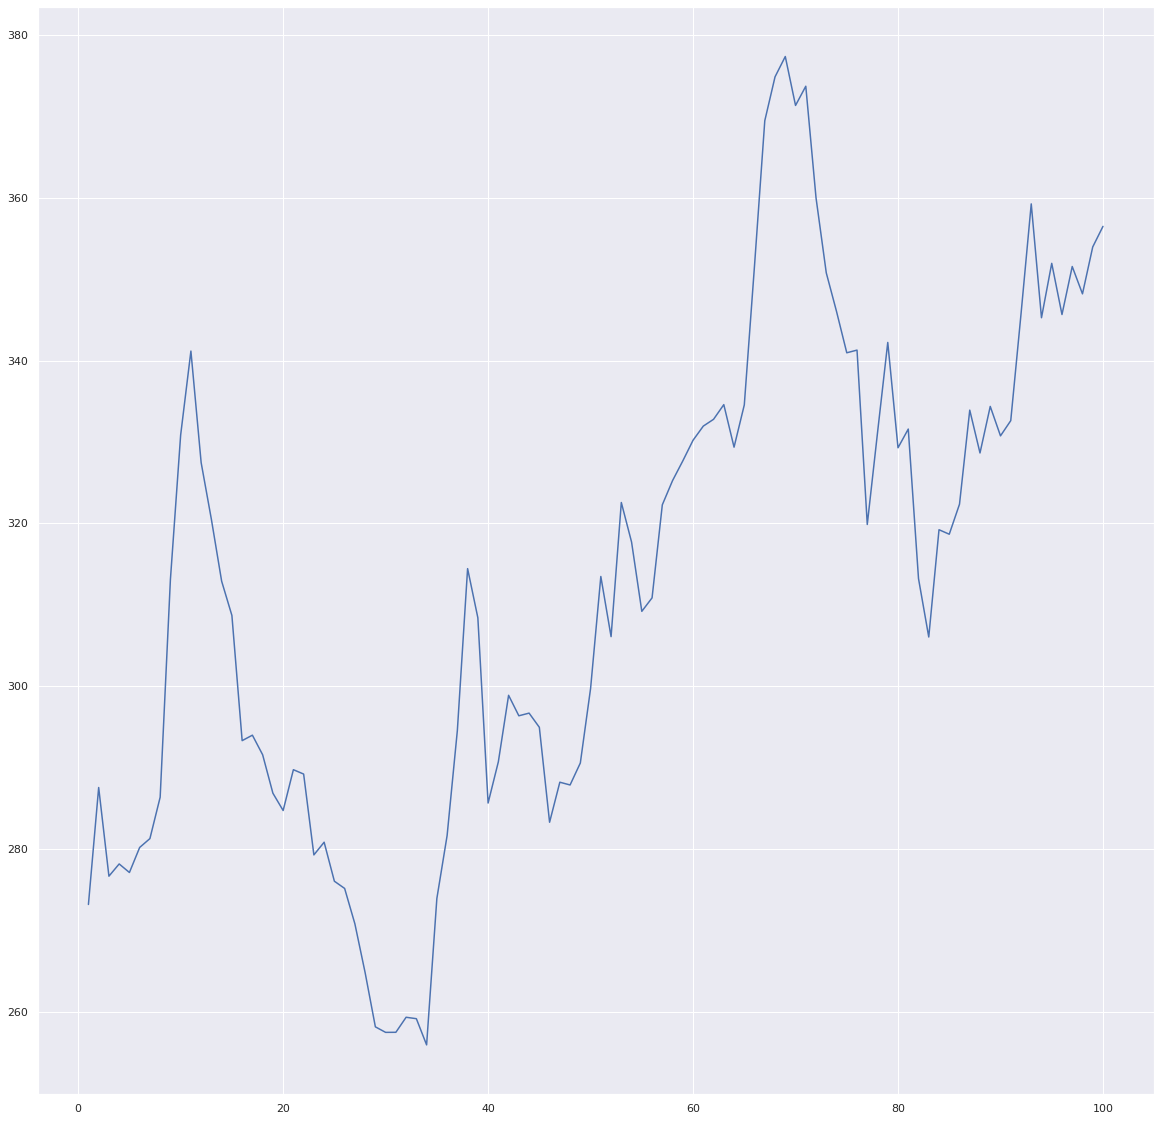

In [25]:
plt.plot(t_value, price_expected[:-1])

## 10000개 Senarios

In [26]:
exp_return_list = []

for log_return_senario in log_return_senario_list:

    exp_return = np.exp(log_return_senario) # e^(v+s*Error)
    exp_return_list.append(exp_return)

In [27]:
price_expected_list = []

for exp_return in exp_return_list:
    price_expected = []
    price_expected.append(df[-1])

    for i in range(len(exp_return)):

        price_expect = price_expected[i] * exp_return[i+1]
        price_expected.append(price_expect)
    price_expected_list.append(price_expected)

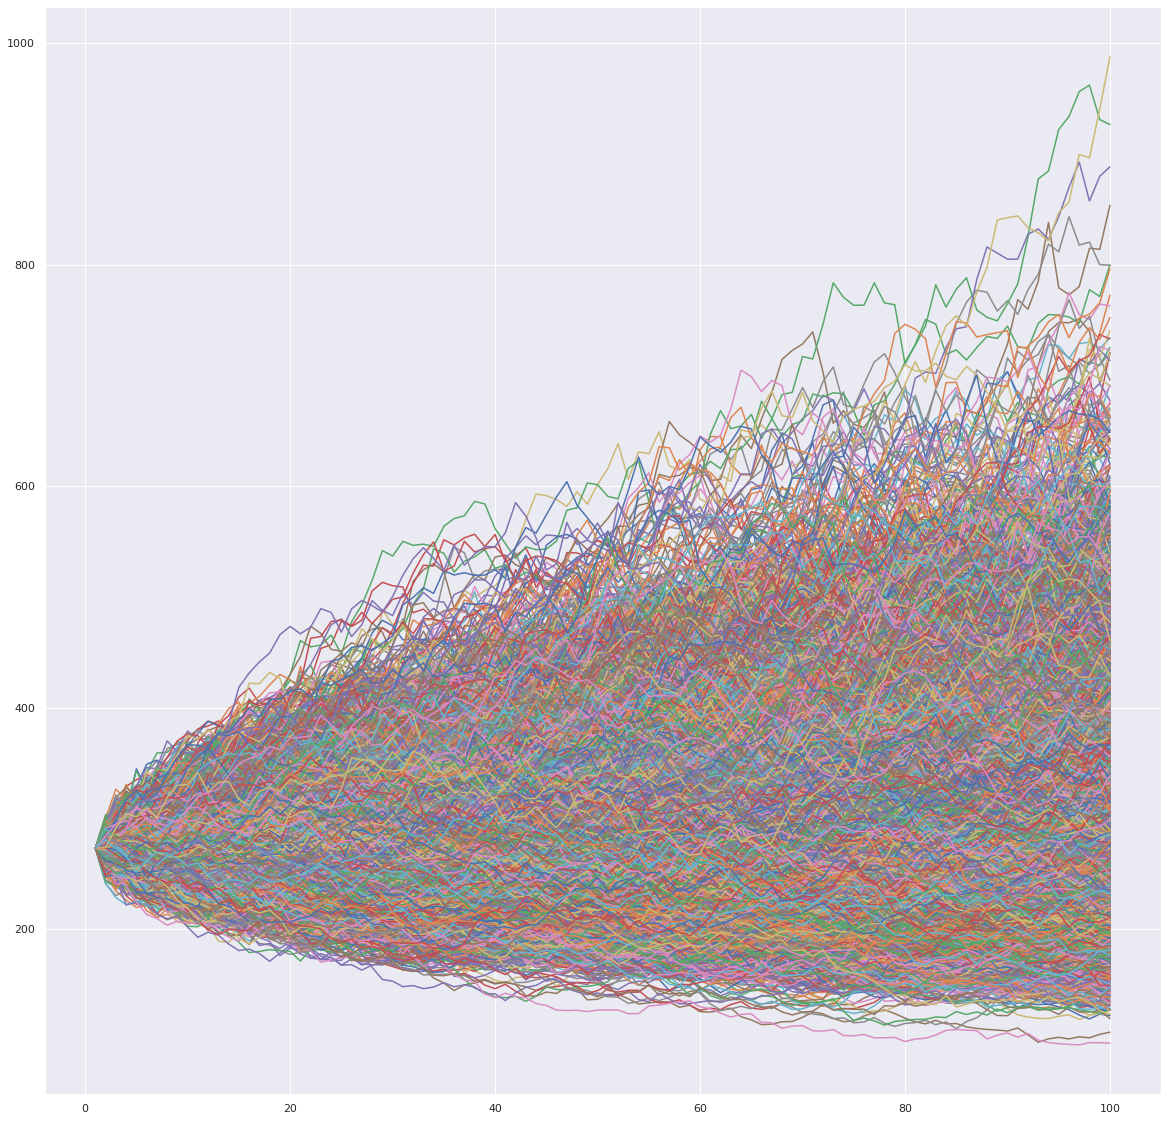

In [28]:
for i in range(len(price_expected_list)):
    plt.plot(t_value, price_expected_list[i][:-1])

## Applying on Option market

# Call option, long 가정 

In [29]:
# T=100 시점이 option 만기일 
# T=100 시점 S(T)와 F(T)비교 

# S(0) * 1.5 = F(T)

Ft = df[-1] * 1.2 # S(0) = historical price 마지막
Opt_price = df[-1] * 0.1 #옵션사는비용 - 이번엔 고려 x  

option_return = []

for price_expect in price_expected_list:
    if price_expect[-1] > Ft : # S(T) > Ft 이면 optin 행사 
        opt_return = (price_expect[-1] - Ft)/ Ft 
    else:  # S(T) <= Ft 이면 optin 행사 x 
        opt_return = 0
    
    option_return.append(opt_return)

## Option 행사한 return들의 distribution 

In [30]:
(np.array(option_return)==0).sum()

6079

In [31]:
#Option 행사안한 비율 

print('option 행사한 개수: ', (np.array(option_return)==0).sum())
print('option 행사하지 않은 개수 : ', len(option_return)- (np.array(option_return)==0).sum())
print('option 행사비율: ', (np.array(option_return)==0).sum()/ len(option_return)) 

option 행사한 개수:  6079
option 행사하지 않은 개수 :  3921
option 행사비율:  0.6079


In [35]:
option_exe_return = np.array(option_return)[np.array(option_return)!=0]

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


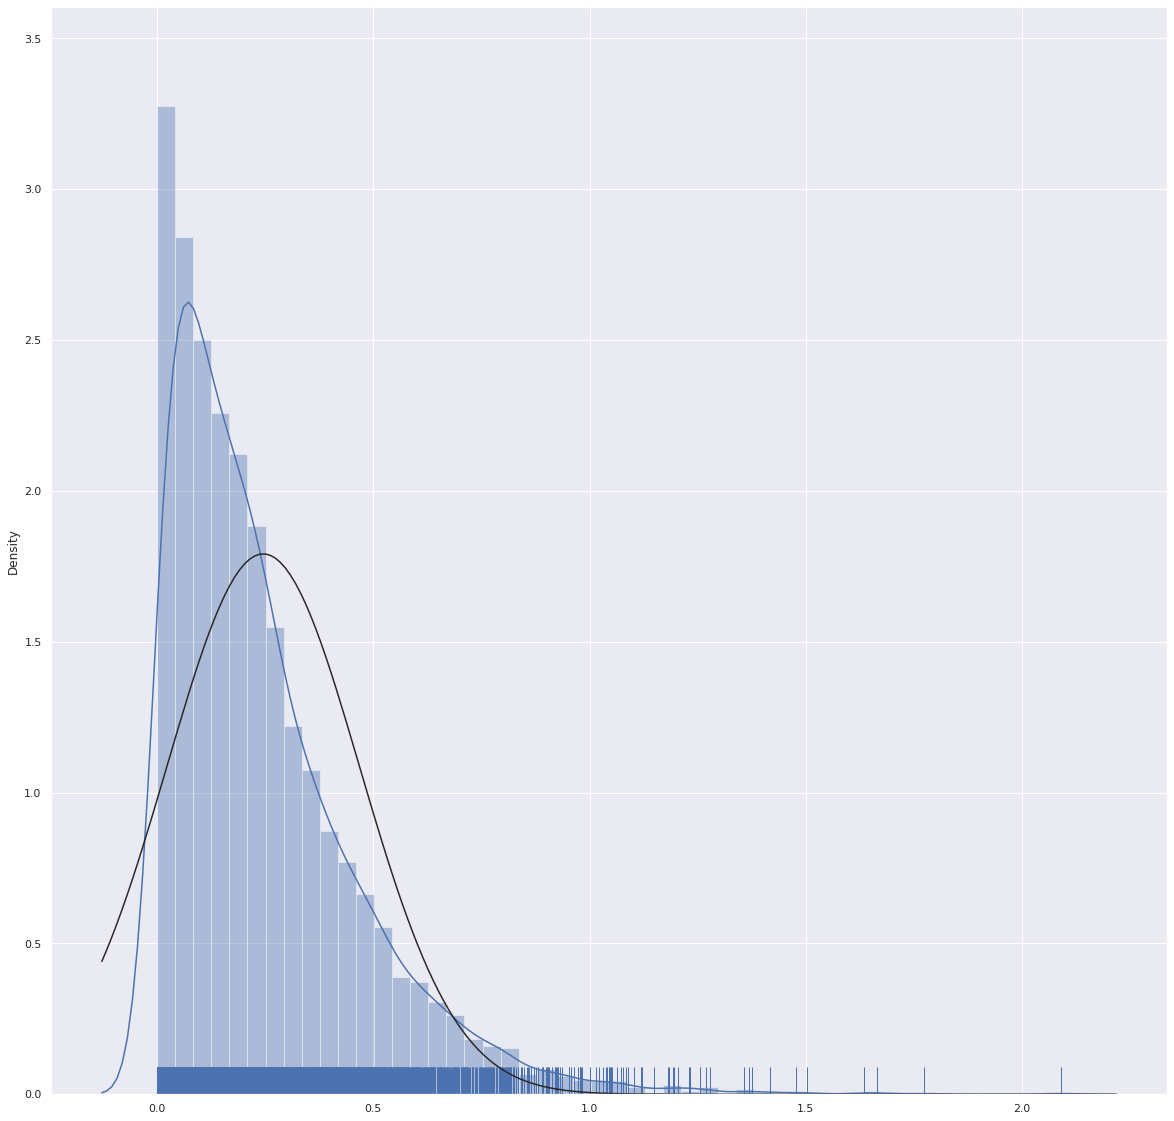

In [36]:
import seaborn as sns
import scipy as sp 

sns.distplot(option_exe_return, kde=True, rug= True, fit=sp.stats.norm)
sns.set(rc={'figure.figsize':(20,20)})

In [39]:
print(np.mean(option_exe_return), np.sqrt(np.var(option_exe_return)))

0.24548045415451908 0.22269601674486889


In [38]:
# 향후 performance 진행할 수 있음 (MDD, CVaR, 다양한 Ratio 등)